# Merchant Fraud Probability Analysis

This notebook demonstrates the findings we have discovered from the merchant fraud data as part of our research. These findings are not shown in our presentation due to complexity and explanability reasons.

## Read Me
We aim to identify statistics that can separate fraudulent merchant and good merchants. Merchant daily orders, customer numbers, revenue by domain knowledge, are indeed relevant features to fraud. However, one challenge we face is that different merchant have different distributions for these features ( Can be shown in the segmentation analysis), so it could be problematic to assume the same distribution and fit the models from it. 

To tackle this problem, we standardize the metrics (Merchant daily orders, customer numbers, revenue) based on its p-value against the historical distribution of each merchant. The p-value has a probabilistic interpretation, which is the likilihood of the observed data conforms the corresponding historical performance. Low p-value indicates that the observed data is an abnomaly. 

The result shows that the p-values do separate the fraudulent merchant and good ones.

We planed to build a k-means clustering model to detect future fraud based on these findings. However, lack of data greatly limits the feasibility to implement this idea. There are also a notable amount of  discrepencies between consumer fraud data and merchant fraud data hence we decide to use a more explanable approach (linear regression model for consumer fraud) instead of using this p-value idea.

In [3]:
# create a spark session
import pandas as pd
import numpy as np
import os
import re
from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

### Check Missing Value


In [4]:
merchant_sdf = spark.read.parquet("../../data/tables/tbl_merchants.parquet")
merchant_df = merchant_sdf.toPandas()
merchant_fraud_df = pd.read_csv("../../data/tables/merchant_fraud_probability.csv")
sdf = spark.read.parquet("../../data/tables/transactions_20220228_20220828_snapshot")

In [5]:
# merchant_sdf.select("merchant_abn").distinct().count() # 4026 entries distince values of merchant
fraud_union = set(merchant_fraud_df["merchant_abn"].unique()) # 61 unique cases
all_union = set(merchant_df["merchant_abn"].unique())
len(all_union.intersection(fraud_union))

48

Only 48/4026 merchants have fraud data
13/61 of the fraud data cannot be matched with any merchant abn

### Read transaction data

In [6]:
from pyspark.sql import functions as F
transaction_df1 = spark.read.parquet("../../data/tables/transactions_20210228_20210827_snapshot")
transaction_df2 = spark.read.parquet("../../data/tables/transactions_20210828_20220227_snapshot")
transaction_df3 = spark.read.parquet("../../data/tables/transactions_20220228_20220828_snapshot")
transaction = transaction_df1.union(transaction_df2).union(transaction_df3)

transaction = transaction.withColumn('log(dollar_value)',
                                     F.log(F.col('dollar_value')))
merchant = spark.read.parquet("../../data/tables/tbl_merchants.parquet")
merchant_abn = merchant.toPandas()['merchant_abn'].unique().tolist()

filtered_transaction = transaction.where(F.col('merchant_abn').isin(merchant_abn))
merchant_daily_transaction = filtered_transaction.groupby(['merchant_abn','order_datetime','user_id']).agg(
    F.countDistinct(F.col('order_id')).alias('no_order'),
    F.sum(F.col('dollar_value')).alias('dollar_amount')
) 
# join merchant daily transaction data and merchant fraud
merchant_fraud_df.to_parquet("../../data/temp/merchant_fraud")
merchant_fraud_sdf = spark.read.parquet("../../data/temp/merchant_fraud")
join_df = merchant_fraud_sdf.join(merchant_daily_transaction, on=["merchant_abn","order_datetime"]).distinct()
# join_df.select("merchant_abn").distinct().count() #48

In [7]:
# join dataframe only contains merchant transaction contained in merchant_fraud data
join_df = merchant_fraud_sdf.join(merchant_daily_transaction, on=["merchant_abn","order_datetime"]).distinct()
agg_sdf = join_df.groupBy(['merchant_abn','order_datetime']).agg(
     F.countDistinct(F.col('user_id')).alias('no_customer'),
     F.sum(F.col("no_order")).alias("total_order"),
     F.avg(F.col("dollar_amount")).alias("avg_dollar_amount"), # changed to avg for independence
     F.mean(F.col("fraud_probability")).alias("fraud_prob")
)

agg_sdf.count() # 95

95

In [8]:
agg_df = agg_sdf.toPandas()

### test normal distribution assumption on the most major merchants

In [9]:
# find most major merchant

test_transaction = filtered_transaction.groupby(['merchant_abn','order_datetime']).agg(
    F.countDistinct(F.col('user_id')).alias('no_customer'),
    F.countDistinct(F.col("order_id")).alias("total_order"),
    F.avg(F.col("dollar_value")).alias("avg_dollar_value"), # changed to average per order for independence
) 


max = test_transaction.groupby("merchant_abn").agg(
    F.sum(F.col("total_order")).alias("total_all_time_order") 
).agg(
    F.max(F.col("total_all_time_order")).alias("max")
).collect()[0]["max"]


max_abn = test_transaction.groupby("merchant_abn").agg(
    F.sum(F.col("total_order")).alias("total_all_time_order") 
).where(
    F.col("total_all_time_order") ==  max
).collect()[0]["merchant_abn"]

In [10]:
# test 2nd and 3rd as well
order_abn = test_transaction.groupby("merchant_abn").agg(
    F.sum(F.col("total_order")).alias("total_all_time_order") 
).orderBy(
    F.col("total_all_time_order"),
    ascending=False
)

In [11]:
max_abn_agg = test_transaction.where(
    F.col("merchant_abn") == max_abn
).toPandas()

snd_abn_agg = test_transaction.where(
    F.col("merchant_abn") == 86578477987
).toPandas()

trd_abn_agg = test_transaction.where(
    F.col("merchant_abn") == 64203420245
).toPandas()

(array([  1.,   1.,  12.,  41.,  94., 146., 165.,  96.,  36.,  14.]),
 array([26.00845407, 26.6825839 , 27.35671373, 28.03084356, 28.70497339,
        29.37910322, 30.05323305, 30.72736288, 31.40149271, 32.07562254,
        32.74975237]),
 <BarContainer object of 10 artists>)

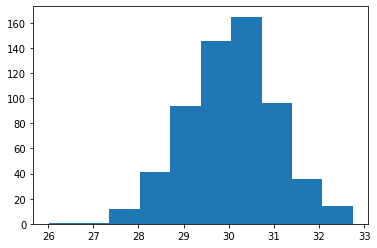

In [12]:
plt.hist(max_abn_agg["avg_dollar_value"])

(array([ 38.,  83., 138., 147., 116.,  59.,  21.,   3.,   0.,   1.]),
 array([32.36590612, 33.1544895 , 33.94307288, 34.73165626, 35.52023964,
        36.30882302, 37.0974064 , 37.88598978, 38.67457316, 39.46315654,
        40.25173992]),
 <BarContainer object of 10 artists>)

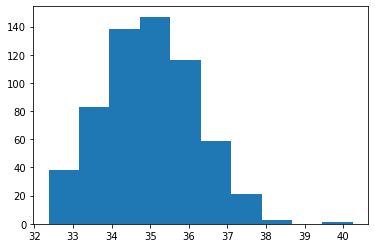

In [13]:
plt.hist(snd_abn_agg["avg_dollar_value"])

(array([  6.,  20.,  81., 167., 161., 117.,  43.,   8.,   2.,   1.]),
 array([26.56451221, 27.13049597, 27.69647972, 28.26246348, 28.82844723,
        29.39443099, 29.96041475, 30.5263985 , 31.09238226, 31.65836601,
        32.22434977]),
 <BarContainer object of 10 artists>)

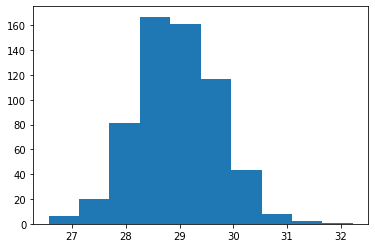

In [14]:
plt.hist(trd_abn_agg["avg_dollar_value"])


(array([125., 255., 164.,  45.,  10.,   1.,   3.,   0.,   2.,   1.]),
 array([ 306. ,  401.4,  496.8,  592.2,  687.6,  783. ,  878.4,  973.8,
        1069.2, 1164.6, 1260. ]),
 <BarContainer object of 10 artists>)

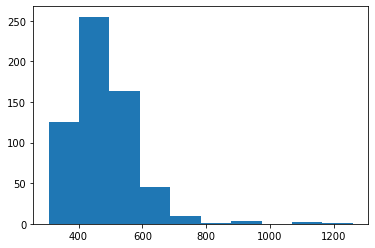

In [15]:
plt.hist(max_abn_agg["total_order"])

(array([108., 242., 185.,  49.,  15.,   1.,   3.,   0.,   0.,   3.]),
 array([ 284. ,  370.1,  456.2,  542.3,  628.4,  714.5,  800.6,  886.7,
         972.8, 1058.9, 1145. ]),
 <BarContainer object of 10 artists>)

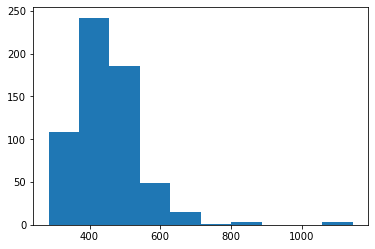

In [16]:
plt.hist(snd_abn_agg["total_order"])

(array([ 57., 249., 211.,  66.,  16.,   1.,   2.,   1.,   2.,   1.]),
 array([ 243.,  332.,  421.,  510.,  599.,  688.,  777.,  866.,  955.,
        1044., 1133.]),
 <BarContainer object of 10 artists>)

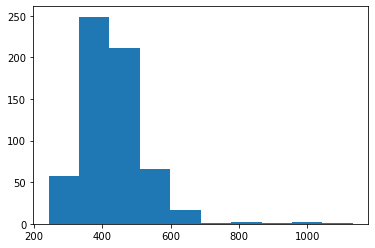

In [17]:
plt.hist(trd_abn_agg["total_order"])

The above graph shows that the assumption of normal distribution for the historical data of the metrics holds.

### standardize the metrics by its historical mean and var

1. find historical mean and var of customer number, total order, total_dollar_amount of each merchant
2. calculate the p-value

In [18]:
# first find the average 
labeled_merchant = merchant_fraud_df['merchant_abn'].unique().tolist()
labeled_merchant_transaction = transaction.where(F.col('merchant_abn').isin(labeled_merchant))

all_time_daily_merchant_transaction = labeled_merchant_transaction.groupby(['merchant_abn','order_datetime']).agg(
    F.countDistinct(F.col('user_id')).alias('no_customer'),
    F.countDistinct(F.col("order_id")).alias("total_order"),
    F.avg(F.col("dollar_value")).alias("avg_dollar_value"), # changed to average per consumer for independence
) 

all_time_daily_merchant_transaction.count()

18656

In [19]:
all_time_agg = all_time_daily_merchant_transaction.groupBy("merchant_abn").agg(
    F.avg(F.col("no_customer")).alias("avg_daily_no_customer"),
    F.stddev(F.col("no_customer")).alias("stddev_daily_no_customer"),
    F.avg(F.col("total_order")).alias("avg_daily_total_order"),
    F.stddev(F.col("total_order")).alias("stddev_daily_total_order"),
    F.avg(F.col("avg_dollar_value")).alias("avg_daily_avg_dollar_value"), # avg customer spending
    F.stddev(F.col("avg_dollar_value")).alias("stddev_daily_avg_dollar_value"),
)

all_time_agg.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- avg_daily_no_customer: double (nullable = true)
 |-- stddev_daily_no_customer: double (nullable = true)
 |-- avg_daily_total_order: double (nullable = true)
 |-- stddev_daily_total_order: double (nullable = true)
 |-- avg_daily_avg_dollar_value: double (nullable = true)
 |-- stddev_daily_avg_dollar_value: double (nullable = true)



In [20]:
#all_time_agg.count() # 61 checked
all_time_agg_df = all_time_agg.toPandas()

In [21]:
# Joint probability 
# assume independence (avg spending and number of customer are independent )
# cdf F(x<X, y<Y) = F(x)F(y)
# since order and customer are highly correlated(almost identical), we choose avg_dollar_value as X and 
# no of orders as Y

from scipy import stats
def two_side_p_val(mean, stddev, test):
    norm_dist = stats.norm(loc=mean, scale=stddev)
    if test > mean:
        return 2* (1-norm_dist.cdf(test))
    else:
        return 2*norm_dist.cdf(test)

def one_side_p_val(mean, stddev, test):
    norm_dist = stats.norm(loc=mean, scale=stddev)
    if test > mean:
        return (1-norm_dist.cdf(test))
    else:
        return norm_dist.cdf(test)

def join_prob_p_val(mux, stdx, muy, stdy, testx, testy):
    distx = stats.norm(loc=mux, scale=stdx)
    disty = stats.norm(loc=muy, scale=stdy)
    joint_prob = distx.cdf(testx) * disty.cdf(testy)
    if joint_prob>0.5:
        return 2* (1-joint_prob)
    else:
        return 2*joint_prob


agg_join_df = all_time_agg_df.merge(agg_df, on="merchant_abn")

agg_join_df["no_order_p_val"] = agg_join_df[['avg_daily_total_order','stddev_daily_total_order',"total_order"]].\
    apply(lambda row:one_side_p_val(row[0],row[1],row[2]),axis=1)

agg_join_df["no_customer_p_val"] = agg_join_df[['avg_daily_no_customer','stddev_daily_no_customer',"no_customer"]].\
    apply(lambda row:one_side_p_val(row[0],row[1],row[2]),axis=1)

agg_join_df["avg_dollar_value_p_val"] = agg_join_df[['avg_daily_avg_dollar_value','stddev_daily_avg_dollar_value',"avg_dollar_amount"]].\
    apply(lambda row:one_side_p_val(row[0],row[1],row[2]),axis=1)


# not good feature, tested by graph
agg_join_df["joint_dist_p_val"] =  agg_join_df[['avg_daily_avg_dollar_value','stddev_daily_avg_dollar_value',\
    'avg_daily_total_order','stddev_daily_total_order','avg_dollar_amount',"total_order"]].\
         apply(lambda row:join_prob_p_val(row[0],row[1],row[2],row[3],row[4],row[5]),axis=1)

# not good feature, tested by graph
# p_val_x * p_val_y
agg_join_df["p_val_multiple"] = agg_join_df[['avg_dollar_value_p_val','no_order_p_val']].apply(lambda row:
np.exp(row[0])*np.exp(row[1]),axis=1)

/Users/ke/opt/anaconda3/envs/ML/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/ke/opt/anaconda3/envs/ML/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/ke/opt/anaconda3/envs/ML/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


### First check if there is any trend within the labeled fraud data

Plot the fraud rate against p-value of the metrics, if there is a linear trend than consider doing a linear regression model.

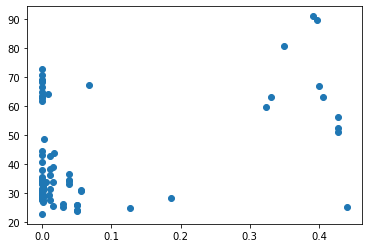

In [22]:
# graphs
agg_join_df = agg_join_df.dropna()
plt.scatter(agg_join_df["no_order_p_val"],agg_join_df["fraud_prob"])
# agg_join_df["no_order_p_val"] = agg_join_df["no_order_p_val"]

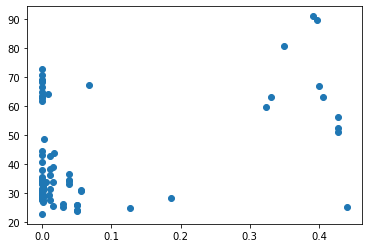

In [23]:
plt.scatter(agg_join_df["no_customer_p_val"],agg_join_df["fraud_prob"])

#plt.scatter(np.log(agg_join_df["no_customer_p_val"]),agg_join_df["fraud_prob"])

In [24]:
agg_join_df.loc[agg_join_df["fraud_prob"] >= 90]

,merchant_abn,avg_daily_no_customer,stddev_daily_no_customer,avg_daily_total_order,stddev_daily_total_order,avg_daily_avg_dollar_value,stddev_daily_avg_dollar_value,order_datetime,no_customer,total_order,avg_dollar_amount,fraud_prob,no_order_p_val,no_customer_p_val,avg_dollar_value_p_val,joint_dist_p_val,p_val_multiple
36,35575706403,1.072464,0.261154,1.072464,0.261154,11275.779495,8551.62989,2022-02-20,1,1,50209.505439,91.096068,0.390707,0.390707,0.000003,0.781413,1.47803


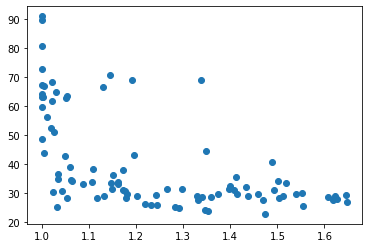

In [25]:

plt.scatter(np.exp(agg_join_df["avg_dollar_value_p_val"]),agg_join_df["fraud_prob"])
# plt.scatter(np.log(agg_join_df["total_dollar_value_p_val"]),agg_join_df["fraud_prob"])


In [26]:
# Joint probability 
# assume independence (avg spending and number of customer are independent )
# cdf F(x<X, y<Y) = F(x)F(y)



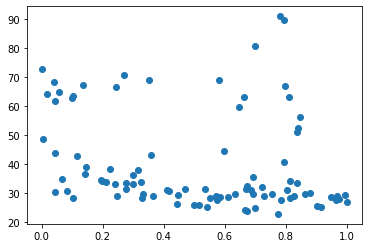

In [27]:
# not optimal....
plt.scatter(agg_join_df["joint_dist_p_val"],agg_join_df["fraud_prob"])

In [28]:
# # p val multiple

# plt.scatter(agg_join_df["p_val_multiple"],agg_join_df["fraud_prob"])

## Then check if the p-value differs the fraud merchant from the good ones 

This is done by checking if their p-value have the same distribution

In [29]:
# agg_join_df.to_csv("../../data/curated/merchant_fraud_join.csv")

### plot the distribution of fraud data

(array([72.,  7.,  1.,  0.,  1.,  0.,  0.,  3.,  1.,  7.]),
 array([3.33066907e-16, 4.39852681e-02, 8.79705362e-02, 1.31955804e-01,
        1.75941072e-01, 2.19926341e-01, 2.63911609e-01, 3.07896877e-01,
        3.51882145e-01, 3.95867413e-01, 4.39852681e-01]),
 <BarContainer object of 10 artists>)

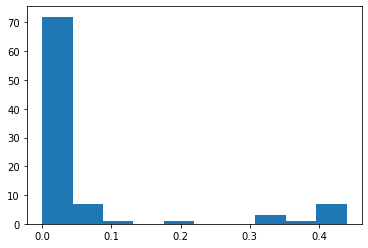

In [30]:
plt.hist(agg_join_df["no_customer_p_val"])

(array([72.,  7.,  1.,  0.,  1.,  0.,  0.,  3.,  1.,  7.]),
 array([3.33066907e-16, 4.39852681e-02, 8.79705362e-02, 1.31955804e-01,
        1.75941072e-01, 2.19926341e-01, 2.63911609e-01, 3.07896877e-01,
        3.51882145e-01, 3.95867413e-01, 4.39852681e-01]),
 <BarContainer object of 10 artists>)

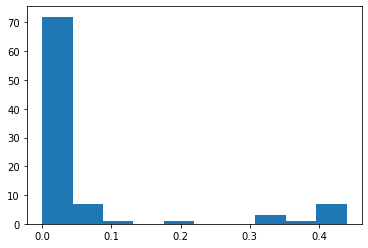

In [31]:
plt.hist(agg_join_df["no_order_p_val"])

(array([25.,  6., 10., 10.,  5.,  8.,  8.,  6.,  8.,  6.]),
 array([2.22044605e-16, 4.98926531e-02, 9.97853062e-02, 1.49677959e-01,
        1.99570612e-01, 2.49463266e-01, 2.99355919e-01, 3.49248572e-01,
        3.99141225e-01, 4.49033878e-01, 4.98926531e-01]),
 <BarContainer object of 10 artists>)

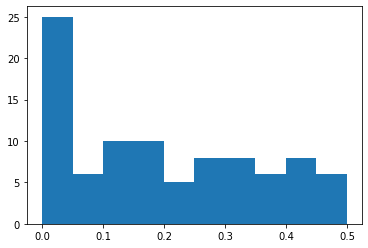

In [32]:
plt.hist(agg_join_df["avg_dollar_value_p_val"])


### Plot the normal (population) data

In [33]:
# use transaction 3 as normal data
non_fraud_transaction_agg = transaction_df3.groupby(['merchant_abn','order_datetime','user_id']).agg(
    F.countDistinct(F.col('order_id')).alias('no_order'),
    F.sum(F.col('dollar_value')).alias('dollar_amount')
) 

non_fraud_agg_sdf = non_fraud_transaction_agg.groupBy(['merchant_abn','order_datetime']).agg(
     F.countDistinct(F.col('user_id')).alias('no_customer'),
     F.sum(F.col("no_order")).alias("total_order"),
     F.avg(F.col("dollar_amount")).alias("avg_dollar_amount"), # changed to avg for independence
)

non_fraud_agg_df = non_fraud_agg_sdf.toPandas()

non_fraud_agg_join_df = all_time_agg_df.merge(non_fraud_agg_df, on="merchant_abn")

non_fraud_agg_join_df["no_order_p_val"] = non_fraud_agg_join_df[['avg_daily_total_order','stddev_daily_total_order',"total_order"]].\
    apply(lambda row:one_side_p_val(row[0],row[1],row[2]),axis=1)

non_fraud_agg_join_df["no_customer_p_val"] = non_fraud_agg_join_df[['avg_daily_no_customer','stddev_daily_no_customer',"no_customer"]].\
    apply(lambda row:one_side_p_val(row[0],row[1],row[2]),axis=1)

non_fraud_agg_join_df["avg_dollar_value_p_val"] = non_fraud_agg_join_df[['avg_daily_avg_dollar_value','stddev_daily_avg_dollar_value',"avg_dollar_amount"]].\
    apply(lambda row:one_side_p_val(row[0],row[1],row[2]),axis=1)



22/10/13 16:19:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/13 16:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/13 16:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/13 16:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/13 16:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/13 16:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/13 16:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/13 16:19:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/13 16:19:54 WARN RowBasedKeyValueBatch: Calling spill() on

(array([580., 527., 731., 796., 884., 762., 846., 805., 802., 792.]),
 array([2.52466936e-11, 4.99965905e-02, 9.99931810e-02, 1.49989772e-01,
        1.99986362e-01, 2.49982953e-01, 2.99979543e-01, 3.49976134e-01,
        3.99972724e-01, 4.49969314e-01, 4.99965905e-01]),
 <BarContainer object of 10 artists>)

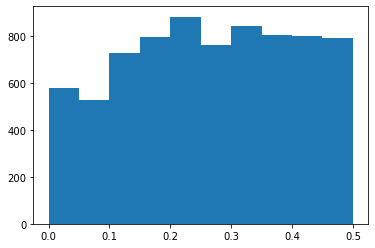

In [34]:
plt.hist(non_fraud_agg_join_df["avg_dollar_value_p_val"])

(array([ 415.,  478.,  404.,  696.,  792., 1265., 1002.,  960.,  972.,
         526.]),
 array([1.67111959e-08, 4.99560866e-02, 9.99121564e-02, 1.49868226e-01,
        1.99824296e-01, 2.49780366e-01, 2.99736436e-01, 3.49692506e-01,
        3.99648576e-01, 4.49604645e-01, 4.99560715e-01]),
 <BarContainer object of 10 artists>)

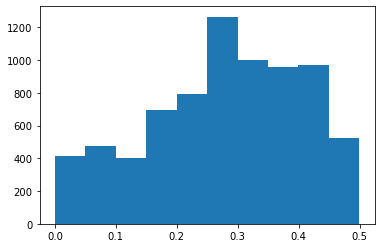

In [35]:
plt.hist(non_fraud_agg_join_df["no_order_p_val"])

(array([ 411.,  486.,  409.,  704.,  774., 1281.,  988.,  944.,  983.,
         530.]),
 array([1.67111959e-08, 4.99512915e-02, 9.99025664e-02, 1.49853841e-01,
        1.99805116e-01, 2.49756391e-01, 2.99707666e-01, 3.49658940e-01,
        3.99610215e-01, 4.49561490e-01, 4.99512765e-01]),
 <BarContainer object of 10 artists>)

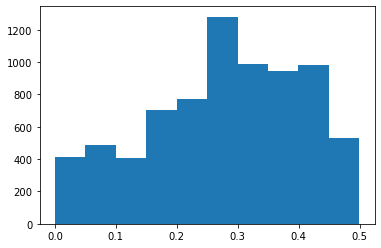

In [36]:
plt.hist(non_fraud_agg_join_df["no_customer_p_val"])

dollar amount it self has a nice negtaive relation
when we use joint prob it is almost uniformly distributed
it appears to be the dollar amount is the most significant feature in terms of determine fraud probability

This doesn't suggest that other features we have are noises. Maybe the other features contributes to distinguish the fraud from the normal ones.

## check interaction between consumer fraud and merchant fraud

The question to answer is, are consumer fraud indicative of merchant fraud?

In [37]:
# consumer: fraud_order_share, fraud_consumer_share, weighted_fraud_value_share
consumer_fraud_sdf = spark.read.parquet("../../data/curated/consumer_fraud.parquet")

merchant_transaction_on_fraud_day = labeled_merchant_transaction.join(merchant_fraud_sdf.withColumnRenamed("fraud_probability", "merchant_fraud_prob"),on=["merchant_abn","order_datetime"])

# merchant_transaction_on_fraud_day_with_consumer_prob = merchant_transaction_on_fraud_day.join(consumer_fraud_sdf.withColumnRenamed("fraud_probability","consumer_fraud_prob").select(""), on="order_datetime"])

merchant_agg_on_fraud_day = merchant_transaction_on_fraud_day.groupBy(["merchant_abn","order_datetime"]).agg(
    F.countDistinct(F.col('user_id')).alias('no_customer'),
    F.countDistinct(F.col("order_id")).alias("no_order"),
    F.sum(F.col("dollar_value")).alias("sum_dollar_value"), 
)

In [38]:
fraud_transaction = merchant_transaction_on_fraud_day.join(consumer_fraud_sdf.withColumnRenamed("fraud_probability","consumer_fraud_prob").distinct(), on=["user_id", "order_datetime"])


In [39]:
fraud_transaction.head(1)

[Row(user_id=3101, order_datetime=datetime.date(2021, 4, 17), merchant_abn=91880575299, dollar_value=105193.88578925544, order_id='2ab65c8f-11b2-41cb-8889-001ce62c005d', log(dollar_value)=11.563560457722723, merchant_fraud_prob=32.99497823665355, consumer_fraud_prob=91.42192091901347)]

In [40]:
fraud_transaction_agg = fraud_transaction.groupBy(["merchant_abn","order_datetime"]).agg(
    F.sum(F.col("consumer_fraud_prob") * F.col("dollar_value")*0.01).alias("weighted_fraud_value"),
    F.countDistinct(F.col("user_id")).alias("no_fraud_consumer"),
    F.countDistinct(F.col("order_id")).alias("no_fraud_order"),
    F.mean(F.col("merchant_fraud_prob")).alias("merchant_fraud_prob"),   # any other way to work around this? want to preserve merchant_fraud_prob
    F.sum(F.col("consumer_fraud_prob")*0.01).alias("no_fraud_order_weighted"),
)

In [41]:
merchant_fraud_share_agg = merchant_agg_on_fraud_day.join(fraud_transaction_agg, on=["merchant_abn","order_datetime"])\
    .withColumn(
        'fraud_customer_share',
        F.col("no_fraud_consumer")/F.col('no_customer')
    ).withColumn(
        'fraud_order_share',
        F.col("no_fraud_order_weighted")/F.col('no_order')
    ).withColumn(
        'weighted_fraud_value_share',
        F.col("weighted_fraud_value")/F.col('sum_dollar_value')
    )


In [42]:
merchant_fraud_share_agg_df = merchant_fraud_share_agg.toPandas()

In [43]:
merchant_fraud_share_agg_df.head(1)

,merchant_abn,order_datetime,no_customer,no_order,sum_dollar_value,weighted_fraud_value,no_fraud_consumer,no_fraud_order,merchant_fraud_prob,no_fraud_order_weighted,fraud_customer_share,fraud_order_share,weighted_fraud_value_share
0,11149063370,2021-08-28,1,1,47346.113374,40851.783402,1,1,56.437613,0.862833,1.0,0.862833,0.862833


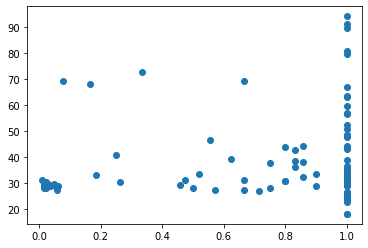

In [44]:
# plot the plots
plt.scatter(merchant_fraud_share_agg_df["fraud_customer_share"], merchant_fraud_share_agg_df["merchant_fraud_prob"])

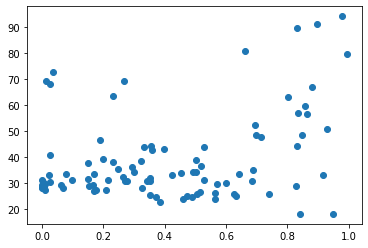

In [45]:
plt.scatter(merchant_fraud_share_agg_df["fraud_order_share"], merchant_fraud_share_agg_df["merchant_fraud_prob"])

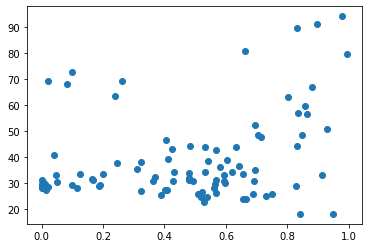

In [46]:
plt.scatter(merchant_fraud_share_agg_df["weighted_fraud_value_share"], merchant_fraud_share_agg_df["merchant_fraud_prob"])

Interaction between fraud consumer and merchant fraud is not obvious